# set up environment

nvidia-smi

In [1]:
# run on hssm_test
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import numpy as np
import pandas as pd
import pathlib
import seaborn
from pathlib import Path 
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrix
from ssms.basic_simulators.simulator import simulator
import bambi as bmb
from pandas.api.types import CategoricalDtype
import ssms
import pytensor  # Graph-based tensor library
import hssm
import random
import math
# Set float type to float32 to avoid a current bug in PyMC 
# This will not be necessary in the future
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


# set up paths

In [13]:
basepath = '/users/afengler/data/proj_tt/mpib-HSSM-oddball-data'

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/models/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/results/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/plots/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/ppc/hssm/').mkdir(parents=True, exist_ok=True)

# set up data

## response as choices

In [3]:
df2 = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')
df2['switch_condition_num']

#dataForModel["trl_condition_bin"] (1==standard, 2==oddball)
#dataForModel["trl_condition"] (1==standard, 2==oddball1,3==oddball2)
choice1=pd.Series([np.nan]*len(df2["trl_condition"]))
for i in range(len(df2["trl_condition"])): 
    if df2["accuracy"].iloc[i] == 1:
        choice1[i]=int(df2["trl_condition"].iloc[i]-1)
    elif df2["accuracy"].iloc[i] == 0 and df2["trl_condition_bin"].iloc[i] == 2:   
        choice1[i]=0
    elif df2["accuracy"].iloc[i] == 0 and df2["trl_condition_bin"].iloc[i] == 1: 
        choice1[i]=random.randint(1, 2)
    
df2['response']=choice1    
df2.rename(columns={'reactiontime': 'rt'}, inplace=True)
df2.rename(columns={'id': 'participant_id'}, inplace=True)

In [4]:
df2

,id_runningnum,participant_id,agegrp,toi1,toi2,offset,trl_runningnum,event,trigger,artfree,...,beta_insula,beta_LC,pupil,LCr,trl_condition_bin,switch_condition,switch_condition_num,logreactiontime,logreactiontimez,response
0,1,42013,1,48306,50806,-1250,1,70,16,1,...,-0.010940,-0.997148,2.175158,0.985568,1,NaN,NaN,0.210081,1.375260,0.0
1,1,42013,1,52293,54793,-1250,2,74,16,1,...,-0.065556,-0.771706,-0.275299,0.985568,1,stay_standard,1.0,-0.174549,-0.033526,0.0
2,1,42013,1,54293,56793,-1250,3,78,16,1,...,0.509185,-0.017799,1.874566,0.985568,2,switch_to_oddball,3.0,0.289645,1.666682,2.0
3,1,42013,1,57293,59793,-1250,4,82,16,1,...,1.049503,-0.247686,-0.516399,0.985568,2,stay_oddball,2.0,0.296416,1.691481,1.0
4,1,42013,1,59293,61793,-1250,5,86,16,1,...,-0.611262,0.441441,0.710667,0.985568,1,switch_to_standard,4.0,-0.418396,-0.926666,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,77,62433,2,463649,466149,-1250,155,657,16,1,...,-0.901538,-1.274403,0.761824,0.386572,1,stay_standard,1.0,-0.137351,-0.110256,0.0
11285,77,62433,2,465649,468149,-1250,156,661,16,1,...,0.026958,-0.852999,-0.115871,0.386572,1,stay_standard,1.0,-0.197492,-0.575755,0.0
11286,77,62433,2,470649,473149,-1250,157,665,16,1,...,-0.940993,1.145411,1.098559,0.386572,2,switch_to_oddball,3.0,0.066526,1.467764,1.0
11287,77,62433,2,472649,475149,-1250,158,669,16,1,...,-0.779456,1.448574,-0.044915,0.386572,1,switch_to_standard,4.0,-0.082262,0.316131,0.0


In [5]:
oddballDataDay2Choice = df2[df2['response'].notna()]

In [6]:
oddballDataDay2Choice

,id_runningnum,participant_id,agegrp,toi1,toi2,offset,trl_runningnum,event,trigger,artfree,...,beta_insula,beta_LC,pupil,LCr,trl_condition_bin,switch_condition,switch_condition_num,logreactiontime,logreactiontimez,response
0,1,42013,1,48306,50806,-1250,1,70,16,1,...,-0.010940,-0.997148,2.175158,0.985568,1,NaN,NaN,0.210081,1.375260,0.0
1,1,42013,1,52293,54793,-1250,2,74,16,1,...,-0.065556,-0.771706,-0.275299,0.985568,1,stay_standard,1.0,-0.174549,-0.033526,0.0
2,1,42013,1,54293,56793,-1250,3,78,16,1,...,0.509185,-0.017799,1.874566,0.985568,2,switch_to_oddball,3.0,0.289645,1.666682,2.0
3,1,42013,1,57293,59793,-1250,4,82,16,1,...,1.049503,-0.247686,-0.516399,0.985568,2,stay_oddball,2.0,0.296416,1.691481,1.0
4,1,42013,1,59293,61793,-1250,5,86,16,1,...,-0.611262,0.441441,0.710667,0.985568,1,switch_to_standard,4.0,-0.418396,-0.926666,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,77,62433,2,463649,466149,-1250,155,657,16,1,...,-0.901538,-1.274403,0.761824,0.386572,1,stay_standard,1.0,-0.137351,-0.110256,0.0
11285,77,62433,2,465649,468149,-1250,156,661,16,1,...,0.026958,-0.852999,-0.115871,0.386572,1,stay_standard,1.0,-0.197492,-0.575755,0.0
11286,77,62433,2,470649,473149,-1250,157,665,16,1,...,-0.940993,1.145411,1.098559,0.386572,2,switch_to_oddball,3.0,0.066526,1.467764,1.0
11287,77,62433,2,472649,475149,-1250,158,669,16,1,...,-0.779456,1.448574,-0.044915,0.386572,1,switch_to_standard,4.0,-0.082262,0.316131,0.0


In [7]:
oddballDataDay2Choice['response'].unique()

array([0., 2., 1.])

In [8]:
oddballDataDay2Choice = oddballDataDay2Choice.copy()
oddballDataDay2Choice = oddballDataDay2Choice[oddballDataDay2Choice['switch_condition_num'].notna()]

oddballDataDay2Choice = oddballDataDay2Choice.reset_index(drop=True)

In [9]:
oddballDataDay2Choice

,id_runningnum,participant_id,agegrp,toi1,toi2,offset,trl_runningnum,event,trigger,artfree,...,beta_insula,beta_LC,pupil,LCr,trl_condition_bin,switch_condition,switch_condition_num,logreactiontime,logreactiontimez,response
0,1,42013,1,52293,54793,-1250,2,74,16,1,...,-0.065556,-0.771706,-0.275299,0.985568,1,stay_standard,1.0,-0.174549,-0.033526,0.0
1,1,42013,1,54293,56793,-1250,3,78,16,1,...,0.509185,-0.017799,1.874566,0.985568,2,switch_to_oddball,3.0,0.289645,1.666682,2.0
2,1,42013,1,57293,59793,-1250,4,82,16,1,...,1.049503,-0.247686,-0.516399,0.985568,2,stay_oddball,2.0,0.296416,1.691481,1.0
3,1,42013,1,59293,61793,-1250,5,86,16,1,...,-0.611262,0.441441,0.710667,0.985568,1,switch_to_standard,4.0,-0.418396,-0.926666,0.0
4,1,42013,1,61293,63793,-1250,6,90,16,1,...,-0.546911,1.490605,0.795430,0.985568,1,stay_standard,1.0,-0.238042,-0.266080,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,77,62433,2,463649,466149,-1250,155,657,16,1,...,-0.901538,-1.274403,0.761824,0.386572,1,stay_standard,1.0,-0.137351,-0.110256,0.0
11160,77,62433,2,465649,468149,-1250,156,661,16,1,...,0.026958,-0.852999,-0.115871,0.386572,1,stay_standard,1.0,-0.197492,-0.575755,0.0
11161,77,62433,2,470649,473149,-1250,157,665,16,1,...,-0.940993,1.145411,1.098559,0.386572,2,switch_to_oddball,3.0,0.066526,1.467764,1.0
11162,77,62433,2,472649,475149,-1250,158,669,16,1,...,-0.779456,1.448574,-0.044915,0.386572,1,switch_to_standard,4.0,-0.082262,0.316131,0.0


## first look at real data RT

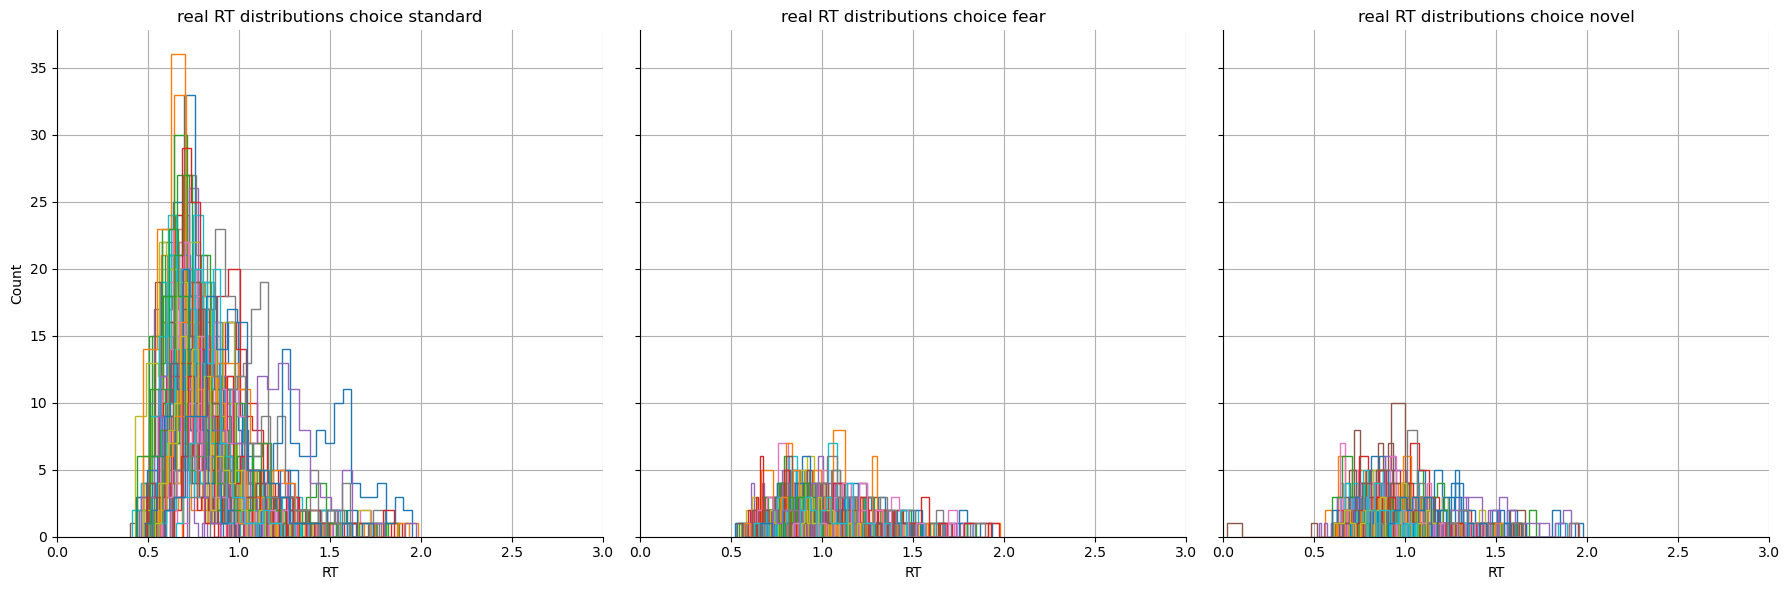

In [10]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']

# Filter data for each response type
dataResponse0 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 0]
dataResponse1 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 1]
dataResponse2 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('real RT distributions choice standard')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('real RT distributions choice fear')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('real RT distributions choice novel')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/rea_subRT_dist_all_choices.pdf')


## day2SubList

In [11]:
# based on the real data, we figure:
# we need to simulate data with 'participant_id','rt',and 'response' 
# we need to get the correct sub numbers out and also correct trial number (samples in simulation) per subject
day2SubList=oddballDataDay2Choice['participant_id'].unique()
len(day2SubList)


71

# simulate subject level data with trial type dependency

## same amount of trials as real data

In [12]:
#sim data
vanillaLBA_SingleSub_trialType_simData=pd.DataFrame()

for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    subData=oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum]

    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(subData)
    
    standardTrials=subData.loc[subData['trl_condition'] == 1]
    fearTrials=subData.loc[subData['trl_condition'] == 2]
    novelTrials=subData.loc[subData['trl_condition'] == 3]

    standardN=len(standardTrials)
    fearN=len(fearTrials)
    novelN=len(novelTrials)


    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    
    choices=[]
    rts=[]
    trialType=[]
    dummyV0=[]
    dummyV1=[]
    dummyV2=[]


    for trial in range(trialNum):
        if subData.iloc[trial].trl_condition==1:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]
            trialV0=1
            trialV1=0
            trialV2=0                                        
        elif subData.iloc[trial].trl_condition==2:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]
            trialV0=0
            trialV1=1
            trialV2=0
        elif subData.iloc[trial].trl_condition==3:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01)
                                                        ]
            trialV0=0
            trialV1=0
            trialV2=1
        # Simulate trial data
        sim_out_trial = simulator(
            theta=[A_true, b_true, v0_true, v1_true, v2_true],  # parameter list
            model="lba3",  # specify model (many are included in ssms)
            n_samples=1,  # number of samples for each set of parameters
        )

        choices=np.append(choices, sim_out_trial["choices"])
        rts=np.append(rts,sim_out_trial["rts"])
        trialType=np.append(trialType,subData.iloc[trial].trl_condition-1)
        dummyV0=np.append(dummyV0,trialV0)
        dummyV1=np.append(dummyV1,trialV1)
        dummyV2=np.append(dummyV2,trialV2)


    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"], rts, choices,trialType,dummyV0,dummyV1,dummyV2]),
        columns=["participant_id", "rt", "response","trial_type","dummyV0","dummyV1","dummyV2"],
    )
        
    # vanillaLBA_SingleSub_trialType_simData.append(subDataset, ignore_index=True)
    vanillaLBA_SingleSub_trialType_simData=pd.concat([vanillaLBA_SingleSub_trialType_simData, subDataset], ignore_index=True)


In [ ]:
vanillaLBA_SingleSub_trialType_simData

,participant_id,rt,response,trial_type,dummyV0,dummyV1,dummyV2
0,42013.0,0.511326,0.0,0.0,1.0,0.0,0.0
1,42013.0,0.541798,2.0,2.0,0.0,0.0,1.0
2,42013.0,0.401961,1.0,1.0,0.0,1.0,0.0
3,42013.0,0.426338,0.0,0.0,1.0,0.0,0.0
4,42013.0,0.533135,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
11159,62433.0,0.545553,0.0,0.0,1.0,0.0,0.0
11160,62433.0,0.437659,0.0,0.0,1.0,0.0,0.0
11161,62433.0,0.555089,1.0,1.0,0.0,1.0,0.0
11162,62433.0,0.507339,0.0,0.0,1.0,0.0,0.0


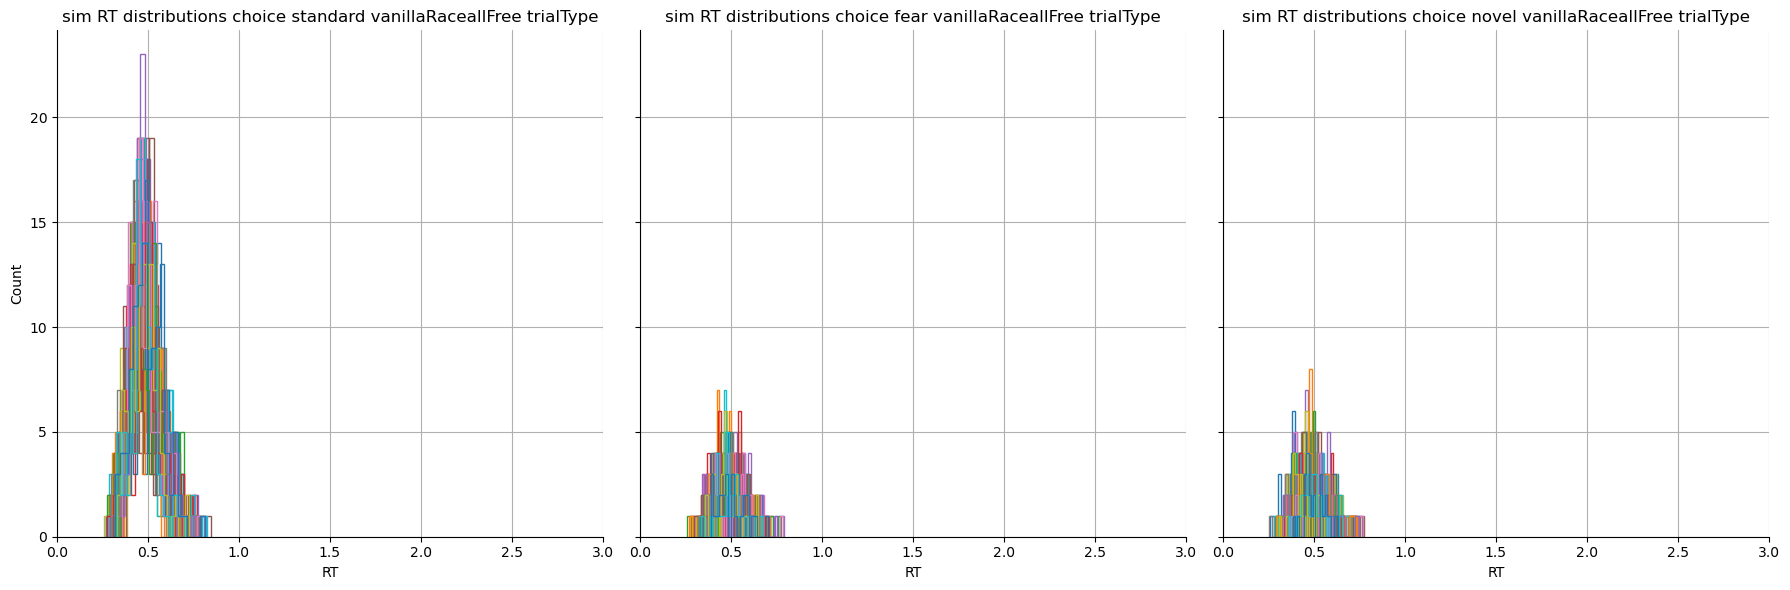

In [ ]:
vanillaLBA_SingleSub_trialType_simData['rtPlot']=vanillaLBA_SingleSub_trialType_simData['rt']

# Filter data for each response type
dataResponse0 = vanillaLBA_SingleSub_trialType_simData.loc[vanillaLBA_SingleSub_trialType_simData['response'] == 0]
dataResponse1 = vanillaLBA_SingleSub_trialType_simData.loc[vanillaLBA_SingleSub_trialType_simData['response'] == 1]
dataResponse2 = vanillaLBA_SingleSub_trialType_simData.loc[vanillaLBA_SingleSub_trialType_simData['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaRaceallFree trialType')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaRaceallFree trialType')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaRaceallFree trialType')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaRaceallFree_trialType.pdf')


In [ ]:
simple_LBA_model_hier_all_noPrior_simData_trialType = hssm.HSSM(
    data=vanillaLBA_SingleSub_trialType_simData,
    model="lba3",
    choices = [0,1,2],
    hierarchical=True,
    noncentered=False,
    loglik_kind="analytical",
    include=[
        {
            "name": "v0",
            "formula": "v0 ~ 1 + (1|participant_id)+(dummyV0|participant_id)",
            "link": "identity",
        },
        {
            "name": "v1",
            "formula": "v1 ~ 1 + (1|participant_id)+(dummyV1|participant_id)",
            "link": "identity",
        },
        {
            "name": "v2",
            "formula": "v2 ~ 1 + (1|participant_id)+(dummyV2|participant_id)",
            "link": "identity",
        }]
    )





Model initialized successfully.


In [ ]:
pathlib.Path(basepath+'/models/lba/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_LBA_model_hier_all_noPrior=simple_LBA_model_hier_all_noPrior_simData_trialType.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=1,
    draws=3000,
    tune=2000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

Using default initvals. 



2024-09-05 11:55:37.717326: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [ ]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_sim_trialType_simple_LBA_model_hier_all_noPrior.nc'
data = inferenceData_simple_LBA_model_hier_all_noPrior
az.to_netcdf(data, fileName)

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/lba/sept24/numpyro/inferenceData_sim_trialType_simple_LBA_model_hier_all_noPrior.nc'

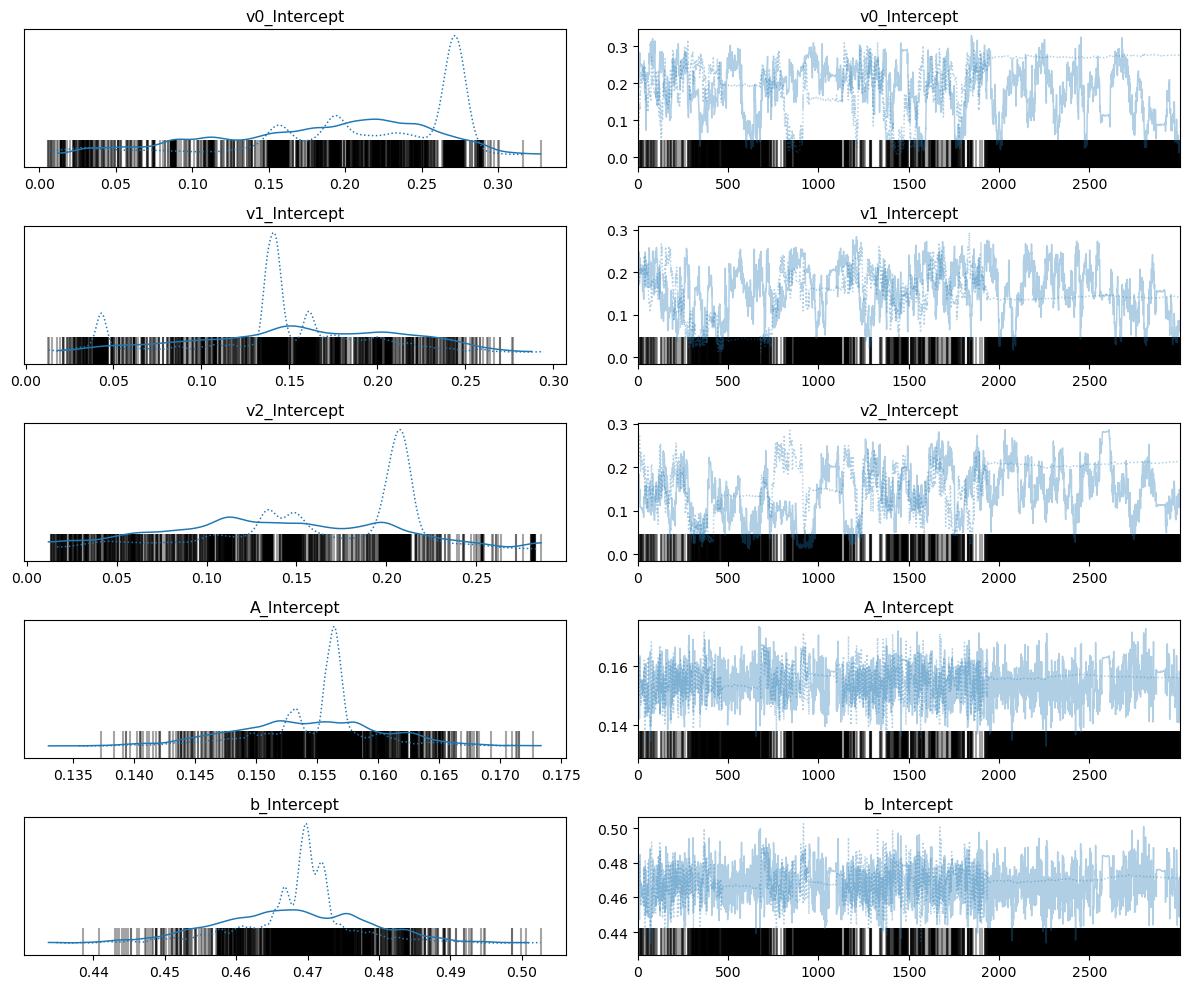

In [ ]:
az.plot_trace(
    simple_LBA_model_hier_all_noPrior_simData_trialType.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

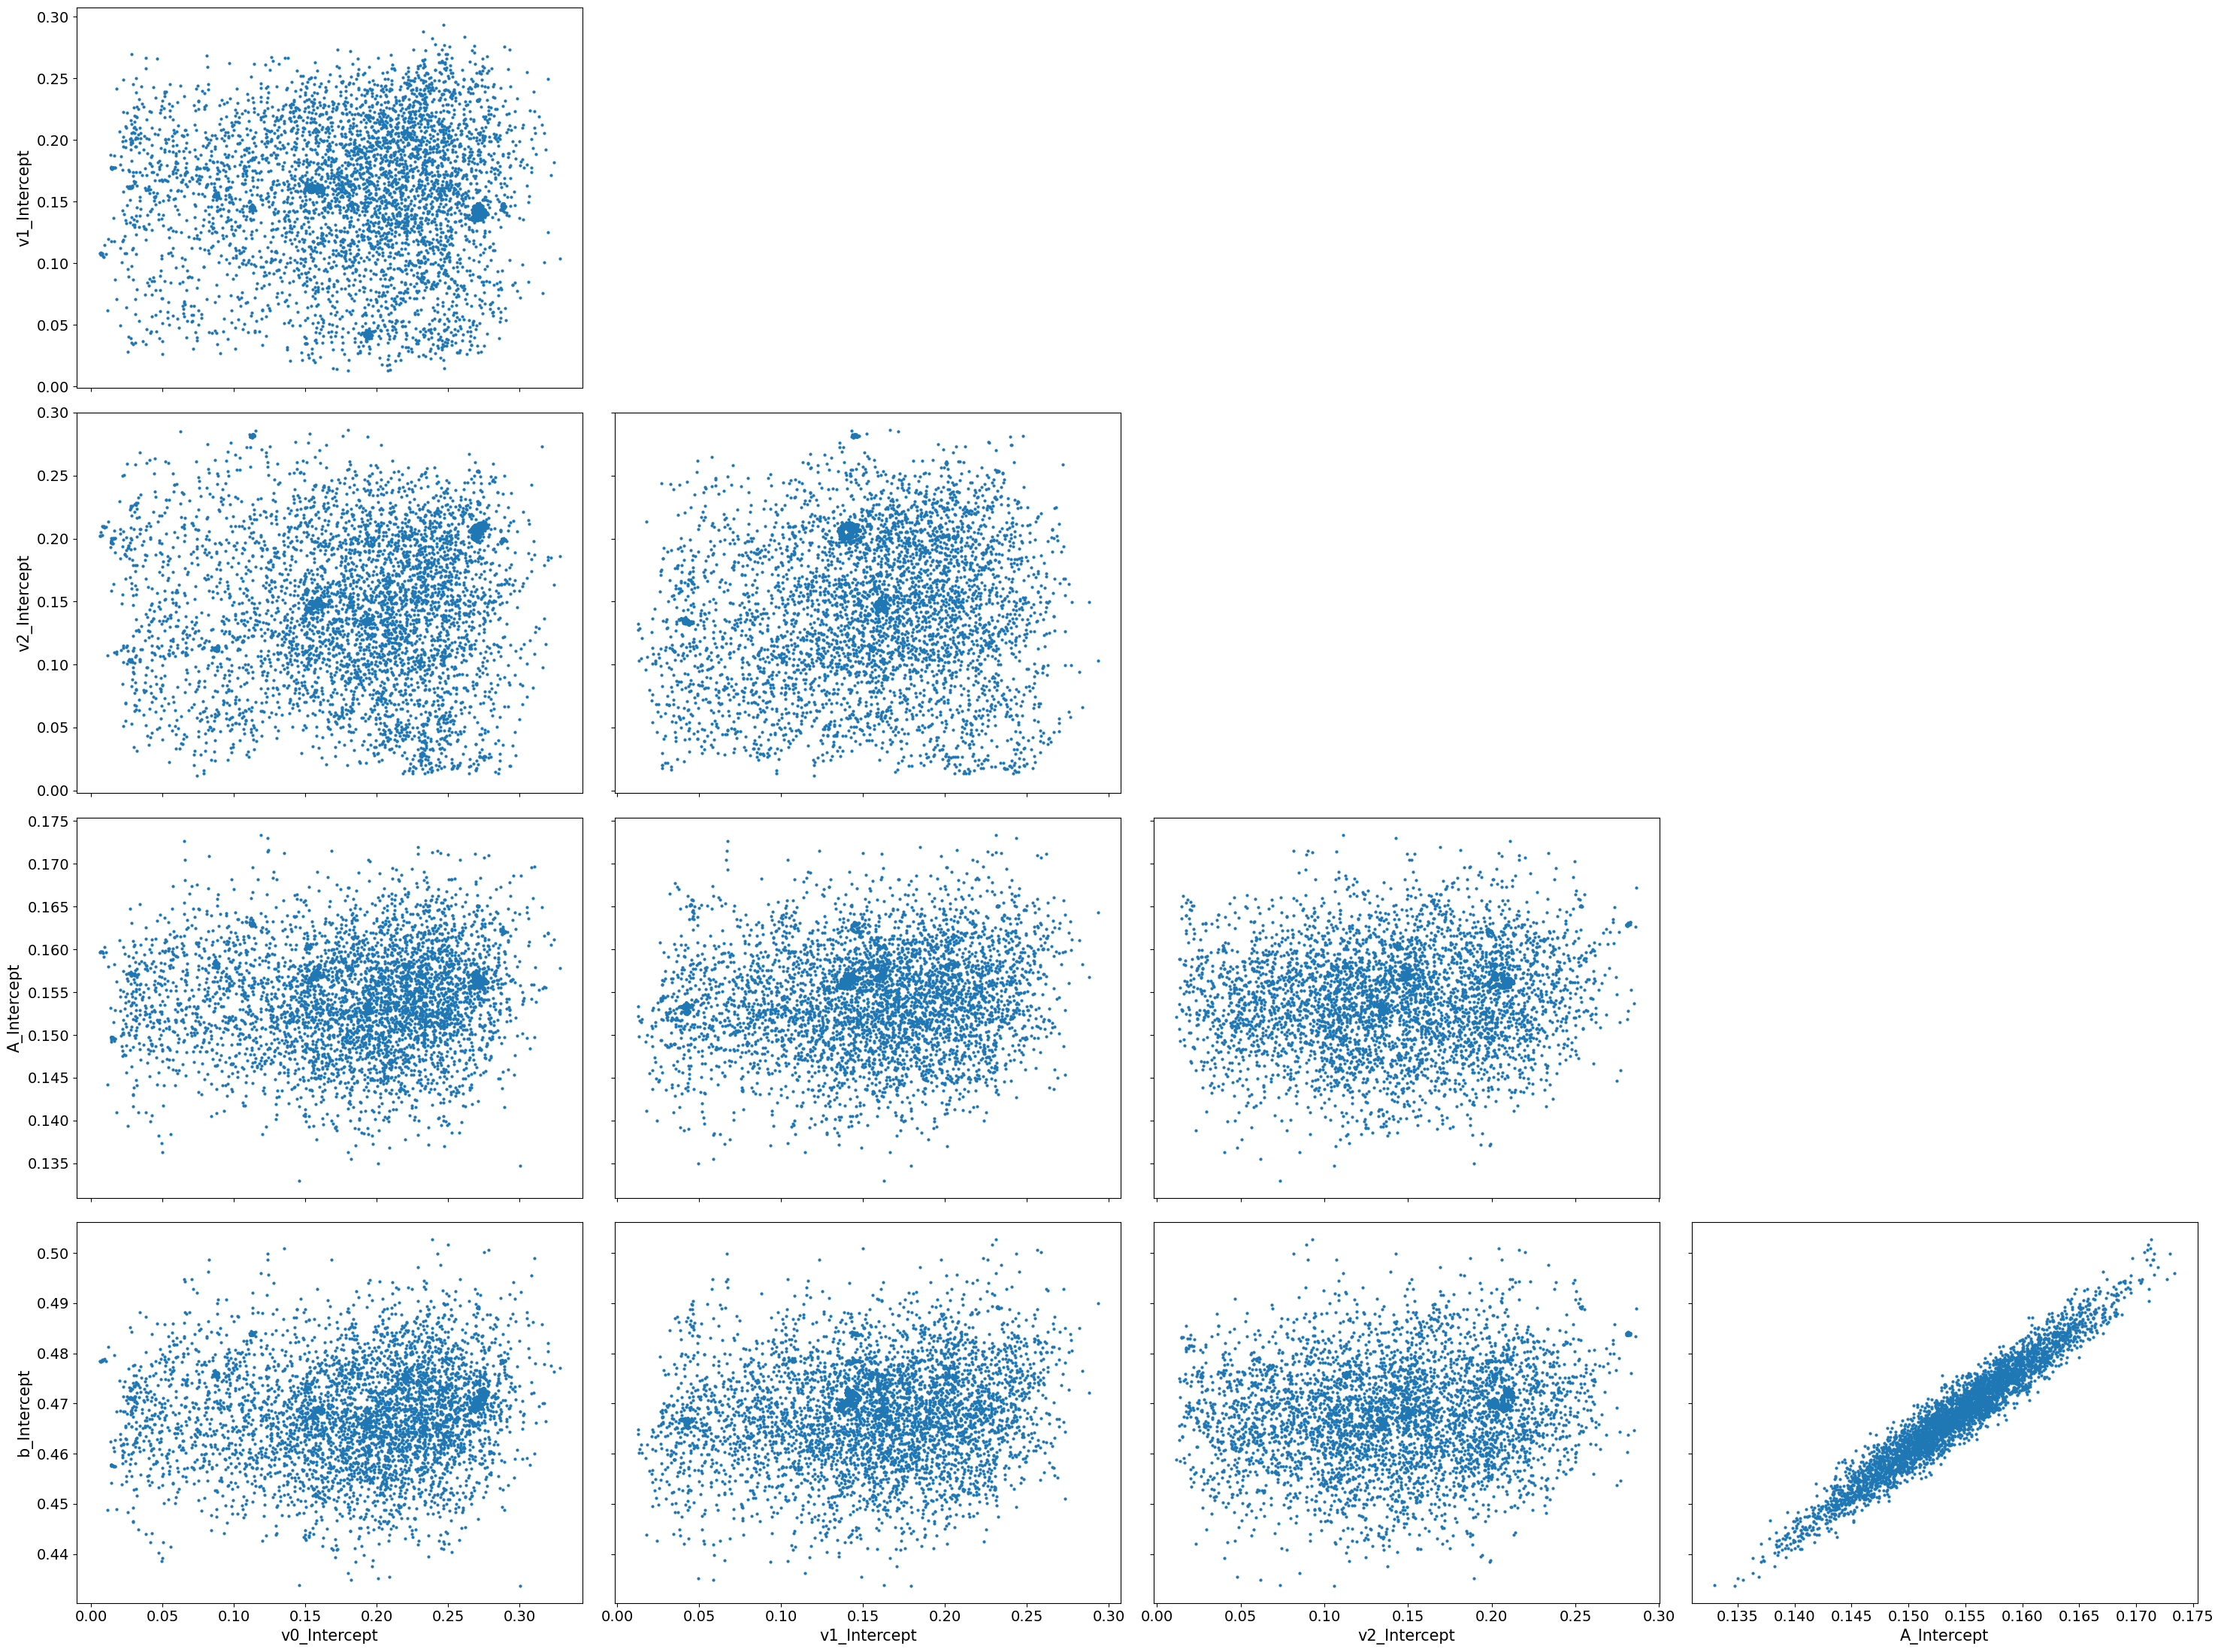

In [ ]:
az.plot_pair(
    simple_LBA_model_hier_all_noPrior_simData_trialType.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

In [ ]:
az.summary(simple_LBA_model_hier_all_noPrior_simData_trialType.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v0_Intercept,0.198,0.069,0.053,0.290,0.023,0.019,8.0,179.0,1.18
v1_Intercept,0.150,0.054,0.039,0.242,0.009,0.006,44.0,44.0,1.18
v2_Intercept,0.153,0.058,0.036,0.241,0.016,0.012,14.0,120.0,1.12
A_Intercept,0.155,0.005,0.143,0.164,0.000,0.000,370.0,908.0,1.16
b_Intercept,0.468,0.009,0.449,0.486,0.000,0.000,394.0,783.0,1.11


## more trials than real data

In [26]:
sub=1
idNum=day2SubList[sub]
    
subData=oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum]

    # figure out trial number from real data for the sub to determine sample numbers in the simulator
trialNum=len(subData)
    
standardTrials=subData.loc[subData['trl_condition'] == 1]
fearTrials=subData.loc[subData['trl_condition'] == 2]
novelTrials=subData.loc[subData['trl_condition'] == 3]

standardN=len(standardTrials)*3
fearN=len(fearTrials)*3
novelN=len(novelTrials)*3

standardTrialsMore=np.ones(standardN)*0
fearTrialsMore=np.ones(fearN)*1
novelTrialsMore=np.ones(novelN)*2

allTrialsMore=np.append(standardTrialsMore,fearTrialsMore)
allTrialsMore=np.append(allTrialsMore,novelTrialsMore)




In [37]:
trialNum

474

In [46]:
#sim data
vanillaLBA_SingleSub_trialType_moreTrials_simData=pd.DataFrame()

for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    subData=oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum]

    
    
    standardTrials=subData.loc[subData['trl_condition'] == 1]
    fearTrials=subData.loc[subData['trl_condition'] == 2]
    novelTrials=subData.loc[subData['trl_condition'] == 3]

    standardN=len(standardTrials)*3
    fearN=len(fearTrials)*3
    novelN=len(novelTrials)*3

    standardTrialsMore=np.ones(standardN)*0
    fearTrialsMore=np.ones(fearN)*1
    novelTrialsMore=np.ones(novelN)*2

    allTrialsMore=np.append(standardTrialsMore,fearTrialsMore)
    allTrialsMore=np.append(allTrialsMore,novelTrialsMore)

    allTrialsMore=np.random.permutation(allTrialsMore)
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(allTrialsMore)


    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    
    choices=[]
    rts=[]
    trialType=[]
    dummyV0=[]
    dummyV1=[]
    dummyV2=[]


    for trial in range(trialNum):
        if allTrialsMore[trial]==0:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]
            trialV0=1
            trialV1=0
            trialV2=0                                        
        elif allTrialsMore[trial]==1:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]
            trialV0=0
            trialV1=1
            trialV2=0
        elif allTrialsMore[trial]==2:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01)
                                                        ]
            trialV0=0
            trialV1=0
            trialV2=1
        
        
        # Simulate trial data
        sim_out_trial = simulator(
            theta=[A_true, b_true, v0_true, v1_true, v2_true],  # parameter list
            model="lba3",  # specify model (many are included in ssms)
            n_samples=1,  # number of samples for each set of parameters
        )

        choices=np.append(choices, sim_out_trial["choices"])
        rts=np.append(rts,sim_out_trial["rts"])
        trialType=np.append(trialType,allTrialsMore[trial])
        dummyV0=np.append(dummyV0,trialV0)
        dummyV1=np.append(dummyV1,trialV1)
        dummyV2=np.append(dummyV2,trialV2)


    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"], rts, choices,trialType,dummyV0,dummyV1,dummyV2]),
        columns=["participant_id", "rt", "response","trial_type","dummyV0","dummyV1","dummyV2"],
    )
        
    # vanillaLBA_SingleSub_trialType_simData.append(subDataset, ignore_index=True)
    vanillaLBA_SingleSub_trialType_moreTrials_simData=pd.concat([vanillaLBA_SingleSub_trialType_moreTrials_simData, subDataset], ignore_index=True)


In [47]:
vanillaLBA_SingleSub_trialType_moreTrials_simData

,participant_id,rt,response,trial_type,dummyV0,dummyV1,dummyV2
0,42013.0,0.519875,0.0,0.0,1.0,0.0,0.0
1,42013.0,0.435804,0.0,0.0,1.0,0.0,0.0
2,42013.0,0.535070,0.0,0.0,1.0,0.0,0.0
3,42013.0,0.367339,0.0,0.0,1.0,0.0,0.0
4,42013.0,0.546364,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
33487,62433.0,0.596753,0.0,0.0,1.0,0.0,0.0
33488,62433.0,0.413619,0.0,0.0,1.0,0.0,0.0
33489,62433.0,0.360282,2.0,2.0,0.0,0.0,1.0
33490,62433.0,0.369013,0.0,0.0,1.0,0.0,0.0


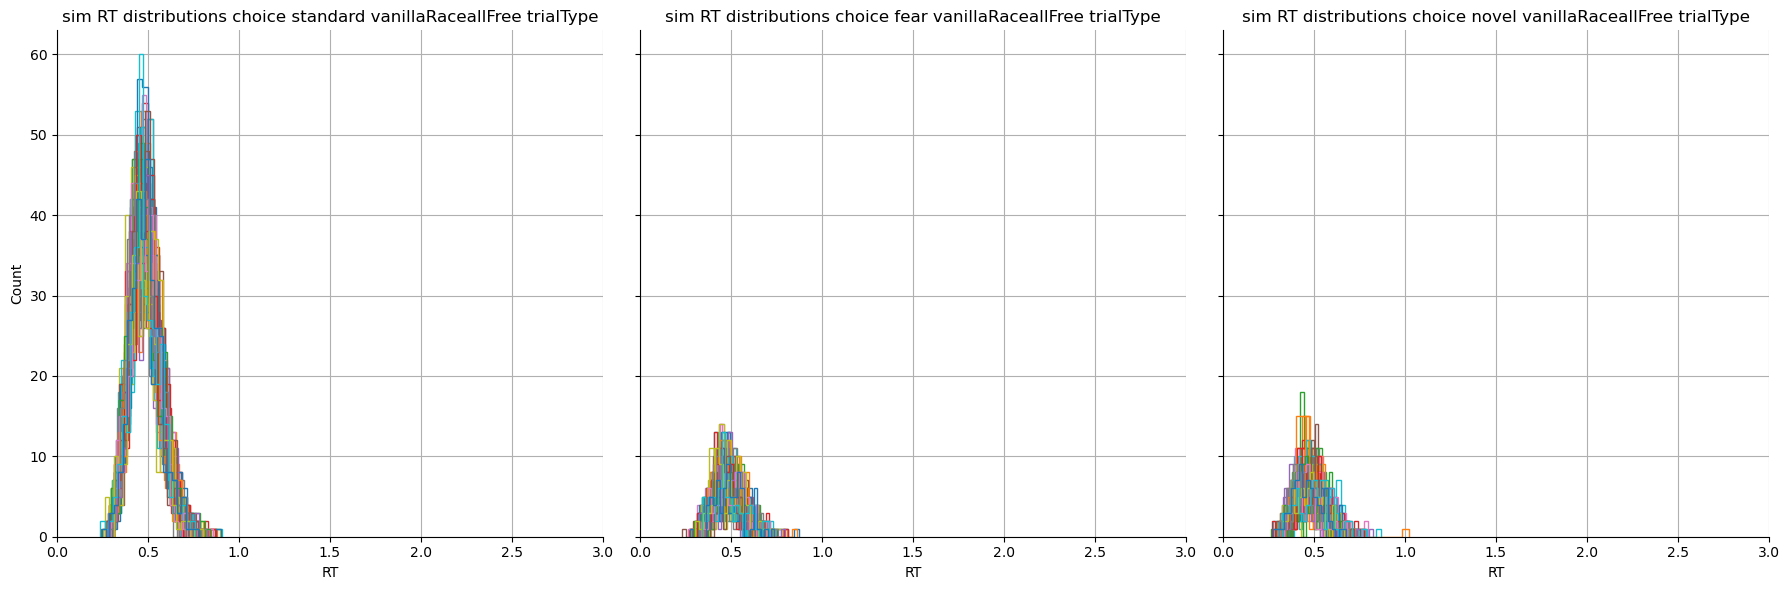

In [48]:
vanillaLBA_SingleSub_trialType_moreTrials_simData['rtPlot']=vanillaLBA_SingleSub_trialType_moreTrials_simData['rt']

# Filter data for each response type
dataResponse0 = vanillaLBA_SingleSub_trialType_moreTrials_simData.loc[vanillaLBA_SingleSub_trialType_moreTrials_simData['response'] == 0]
dataResponse1 = vanillaLBA_SingleSub_trialType_moreTrials_simData.loc[vanillaLBA_SingleSub_trialType_moreTrials_simData['response'] == 1]
dataResponse2 = vanillaLBA_SingleSub_trialType_moreTrials_simData.loc[vanillaLBA_SingleSub_trialType_moreTrials_simData['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaRaceallFree trialType')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaRaceallFree trialType')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaRaceallFree trialType')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaRaceallFree_trialType_moreTrials.pdf')


In [49]:
simple_LBA_model_hier_all_noPrior_simData_trialType_moreTrials = hssm.HSSM(
    data=vanillaLBA_SingleSub_trialType_moreTrials_simData,
    model="lba3",
    choices = [0,1,2],
    hierarchical=True,
    noncentered=False,
    loglik_kind="analytical",
    include=[
        {
            "name": "v0",
            "formula": "v0 ~ 1 + (1|participant_id)+(dummyV0|participant_id)",
            "link": "identity",
        },
        {
            "name": "v1",
            "formula": "v1 ~ 1 + (1|participant_id)+(dummyV1|participant_id)",
            "link": "identity",
        },
        {
            "name": "v2",
            "formula": "v2 ~ 1 + (1|participant_id)+(dummyV2|participant_id)",
            "link": "identity",
        }]
    )





Model initialized successfully.


In [50]:
pathlib.Path(basepath+'/models/lba/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_LBA_model_hier_all_noPrior=simple_LBA_model_hier_all_noPrior_simData_trialType_moreTrials.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=1,
    draws=3000,
    tune=3000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

Using default initvals. 



2024-09-05 13:39:34.245184: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [51]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_sim_trialType_moreTrials_simple_LBA_model_hier_all_noPrior.nc'
data = inferenceData_simple_LBA_model_hier_all_noPrior
az.to_netcdf(data, fileName)

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/lba/sept24/numpyro/inferenceData_sim_trialType_moreTrials_simple_LBA_model_hier_all_noPrior.nc'

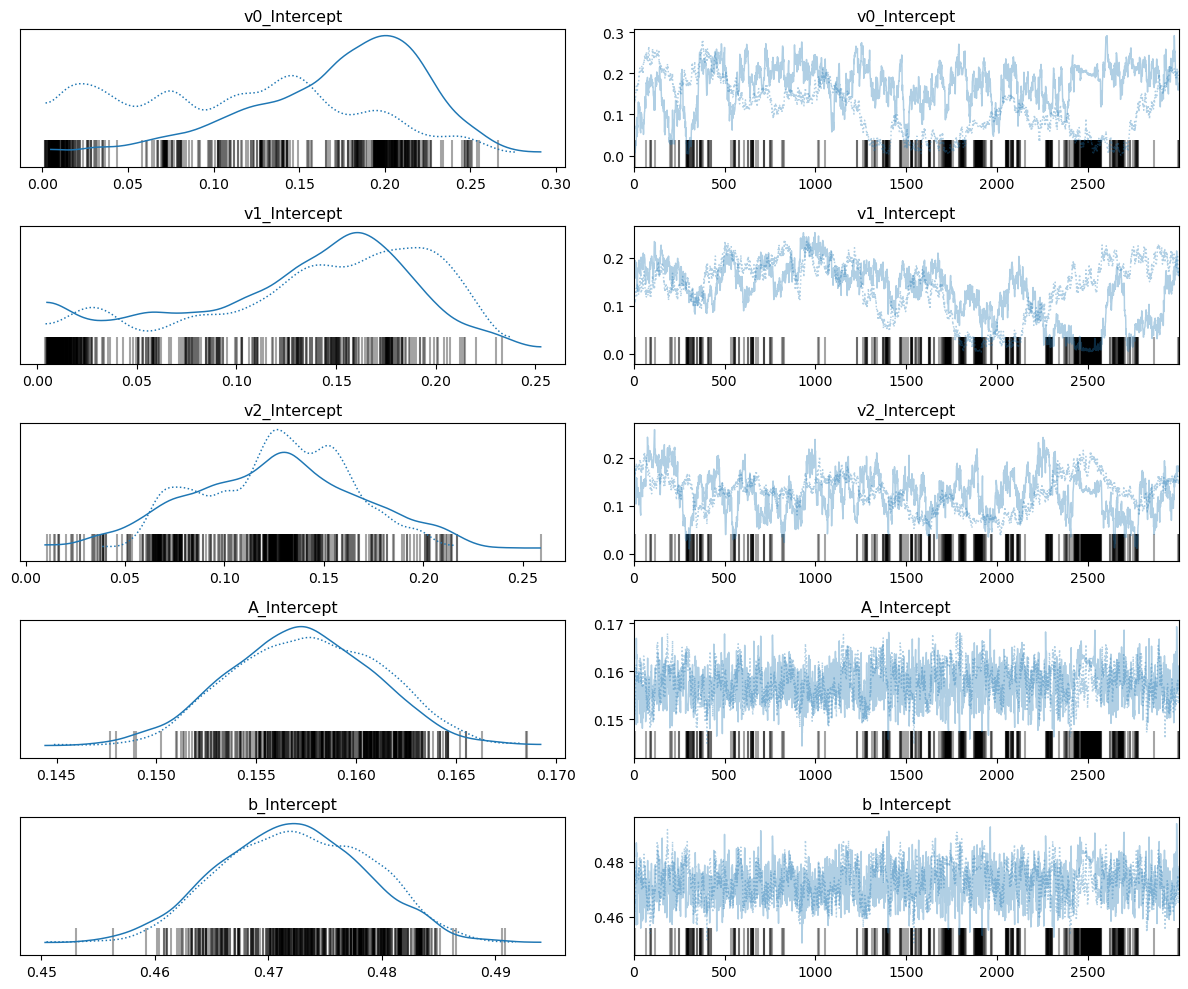

In [52]:
az.plot_trace(
    simple_LBA_model_hier_all_noPrior_simData_trialType_moreTrials.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

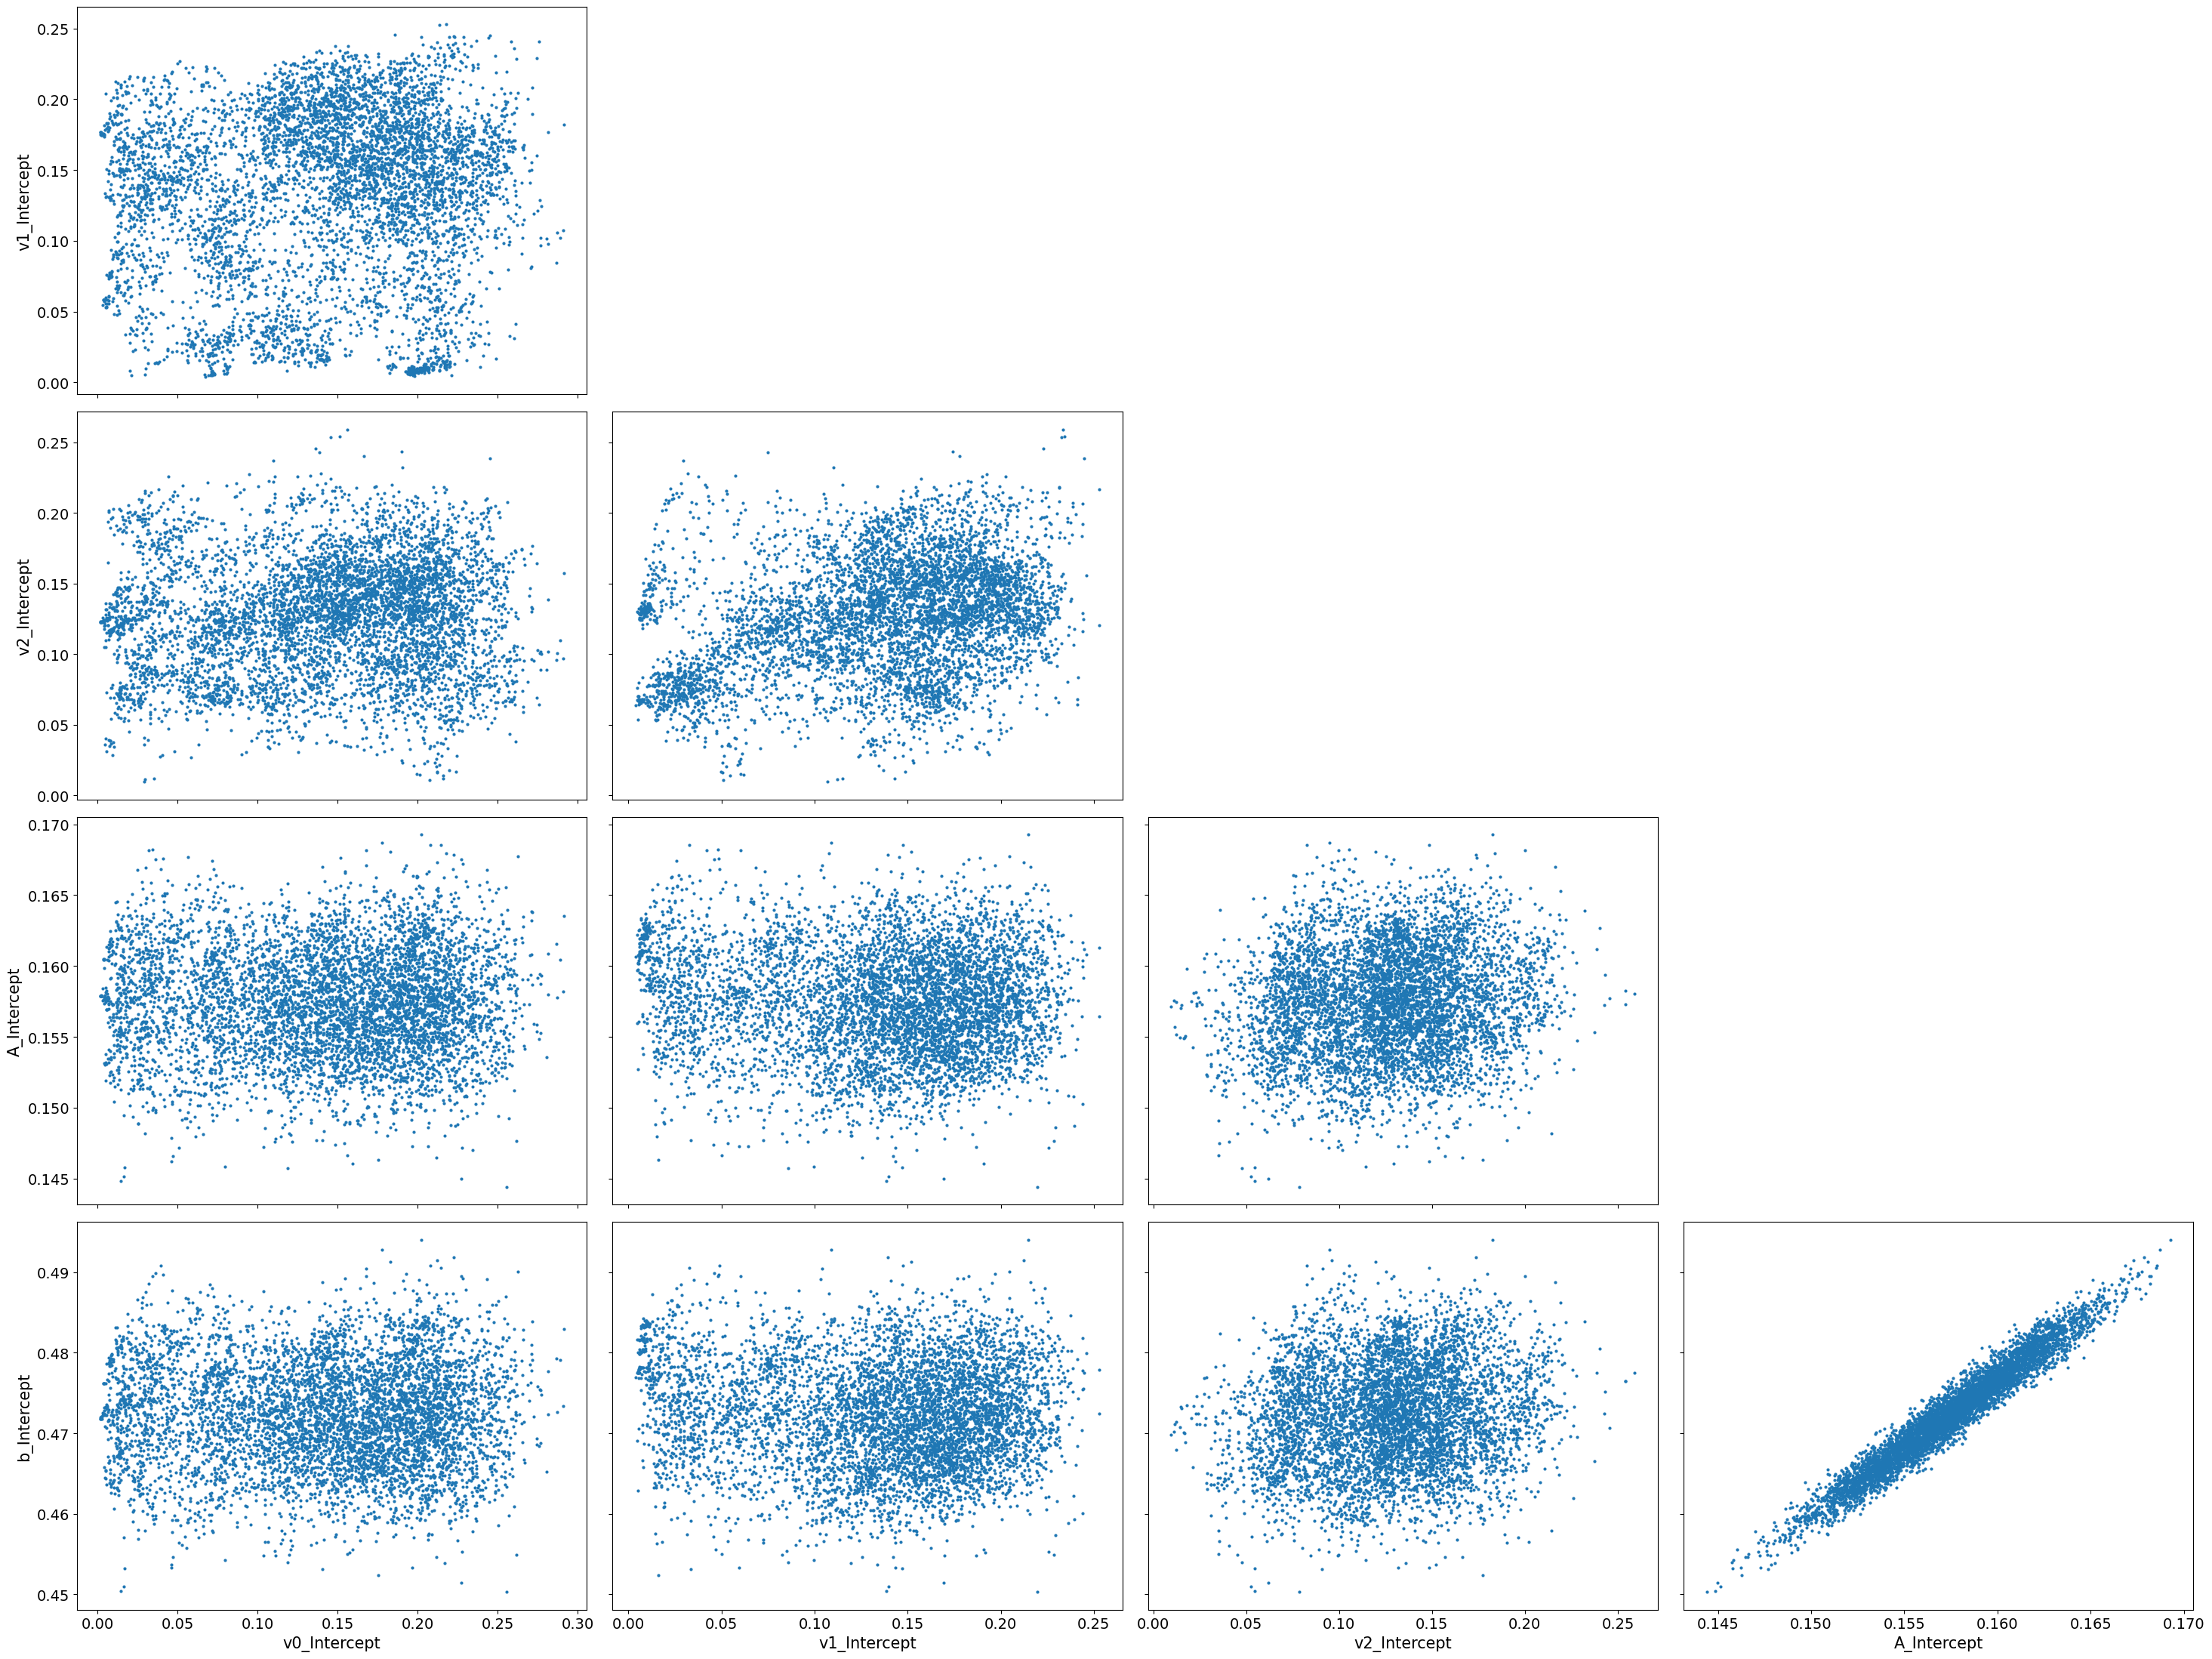

In [53]:
az.plot_pair(
    simple_LBA_model_hier_all_noPrior_simData_trialType_moreTrials.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

In [54]:
az.summary(simple_LBA_model_hier_all_noPrior_simData_trialType_moreTrials.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v0_Intercept,0.143,0.067,0.011,0.241,0.030,0.022,6.0,50.0,1.27
v1_Intercept,0.135,0.058,0.017,0.223,0.019,0.014,10.0,48.0,1.18
v2_Intercept,0.126,0.040,0.057,0.202,0.006,0.004,43.0,113.0,1.05
A_Intercept,0.157,0.004,0.151,0.164,0.000,0.000,362.0,1334.0,1.01
b_Intercept,0.472,0.006,0.461,0.484,0.000,0.000,336.0,772.0,1.01


# real data trial depend hier figure 

In [15]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_simple_LBA_model_trialDepend_hier_.nc'
lba_inferenceData= az.from_netcdf(fileName)


In [16]:
lba_inferenceData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or n

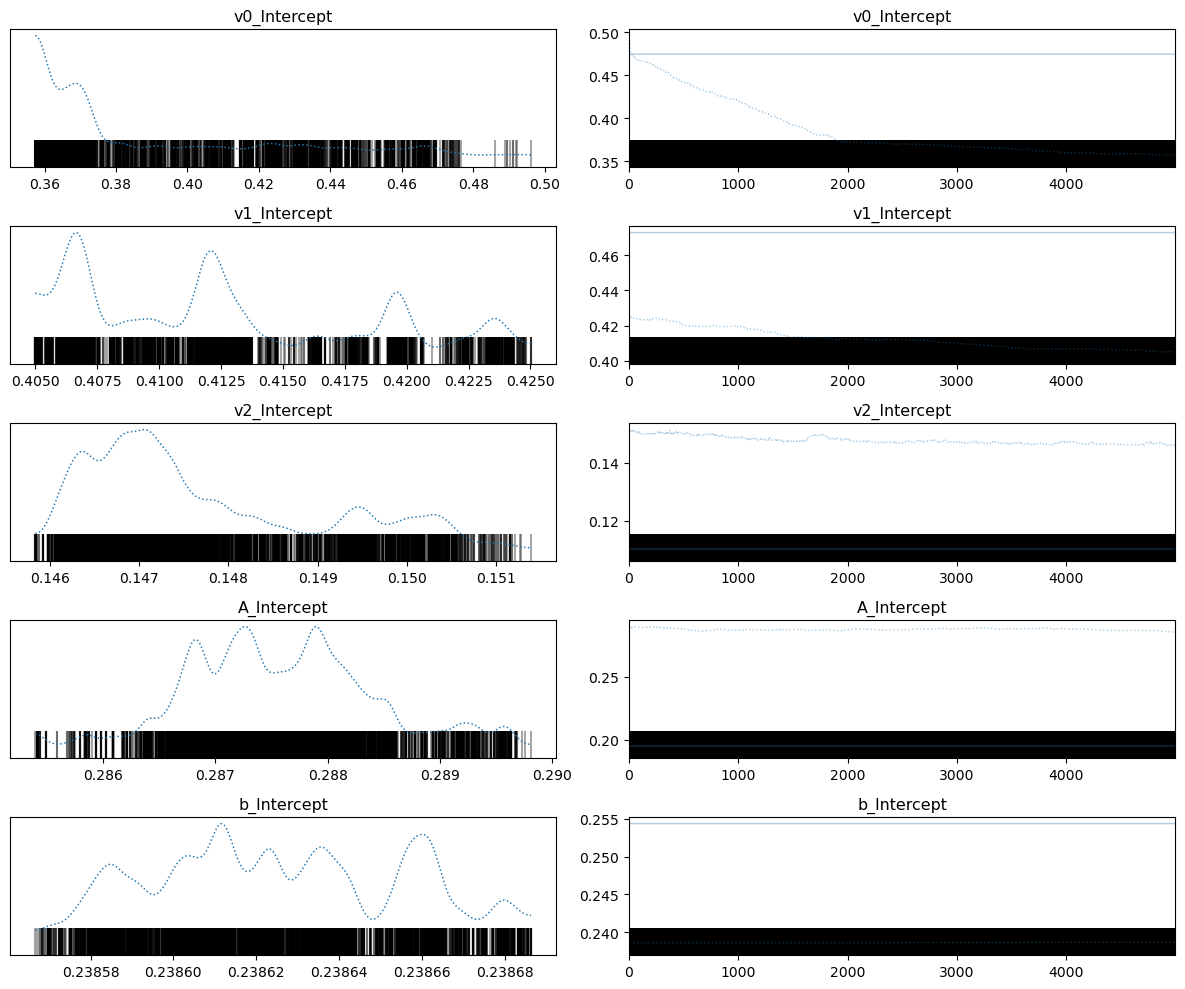

In [17]:
az.plot_trace(
    lba_inferenceData,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

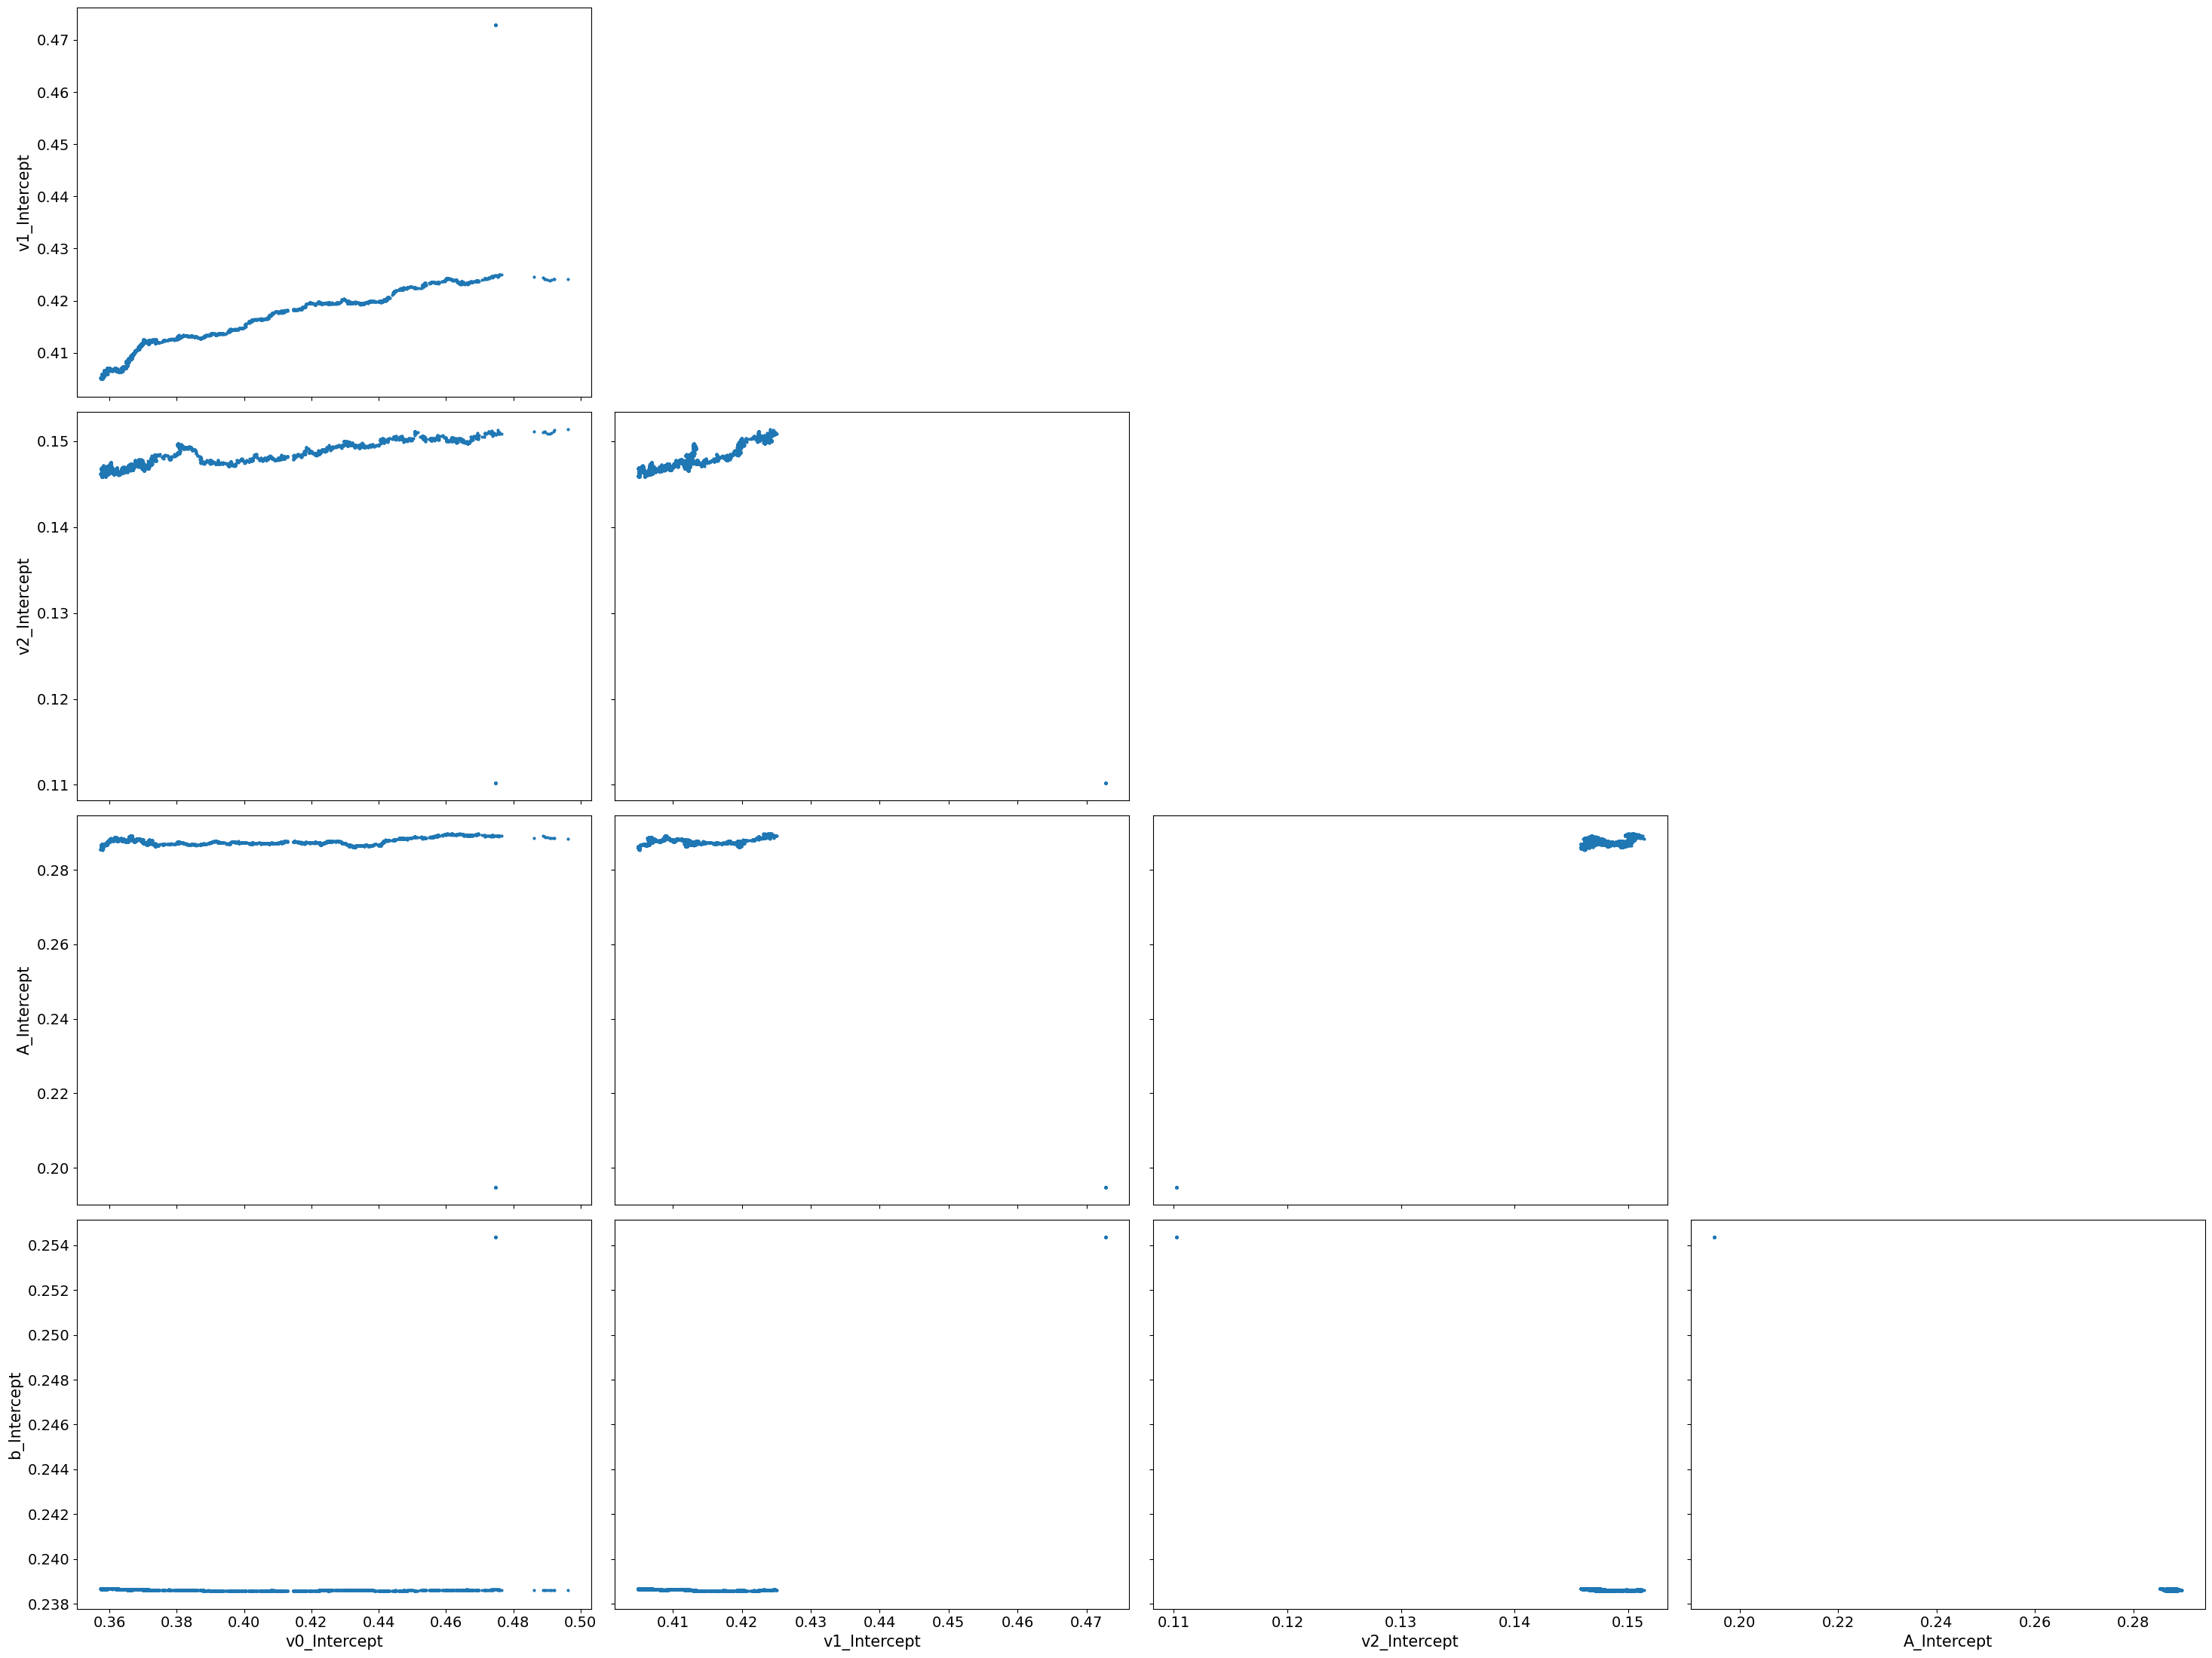

In [18]:
az.plot_pair(
    lba_inferenceData,var_names=['v0_Intercept','v1_Intercept','v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

In [ ]:
az.summary(simple_LBA_model_hier_all_noPrior_simData_trialType_moreTrials.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v0_Intercept,0.143,0.067,0.011,0.241,0.030,0.022,6.0,50.0,1.27
v1_Intercept,0.135,0.058,0.017,0.223,0.019,0.014,10.0,48.0,1.18
v2_Intercept,0.126,0.040,0.057,0.202,0.006,0.004,43.0,113.0,1.05
A_Intercept,0.157,0.004,0.151,0.164,0.000,0.000,362.0,1334.0,1.01
b_Intercept,0.472,0.006,0.461,0.484,0.000,0.000,336.0,772.0,1.01


In [62]:
dummyV0=[]
dummyV1=[]
dummyV2=[]

for trial in range(len(oddballDataDay2Choice)):
    if oddballDataDay2Choice.trl_condition.iloc[trial]==1:
                trialV0=1
                trialV1=0
                trialV2=0 
    elif oddballDataDay2Choice.trl_condition.iloc[trial]==2:
                trialV0=0
                trialV1=1
                trialV2=0 
    elif oddballDataDay2Choice.trl_condition.iloc[trial]==3:
                trialV0=0
                trialV1=0
                trialV2=1 
    dummyV0=np.append(dummyV0,trialV0)
    dummyV1=np.append(dummyV1,trialV1)
    dummyV2=np.append(dummyV2,trialV2)

oddballDataDay2Choice["dummyV0"]=dummyV0
oddballDataDay2Choice["dummyV1"]=dummyV1
oddballDataDay2Choice["dummyV2"]=dummyV2

oddballDataDay2Choice

,id_runningnum,participant_id,agegrp,toi1,toi2,offset,trl_runningnum,event,trigger,artfree,...,trl_condition_bin,switch_condition,switch_condition_num,logreactiontime,logreactiontimez,response,rtPlot,dummyV0,dummyV1,dummyV2
0,1,42013,1,52293,54793,-1250,2,74,16,1,...,1,stay_standard,1.0,-0.174549,-0.033526,0.0,0.839835,1.0,0.0,0.0
1,1,42013,1,54293,56793,-1250,3,78,16,1,...,2,switch_to_oddball,3.0,0.289645,1.666682,2.0,1.335954,0.0,0.0,1.0
2,1,42013,1,57293,59793,-1250,4,82,16,1,...,2,stay_oddball,2.0,0.296416,1.691481,1.0,1.345030,0.0,1.0,0.0
3,1,42013,1,59293,61793,-1250,5,86,16,1,...,1,switch_to_standard,4.0,-0.418396,-0.926666,0.0,0.658101,1.0,0.0,0.0
4,1,42013,1,61293,63793,-1250,6,90,16,1,...,1,stay_standard,1.0,-0.238042,-0.266080,0.0,0.788170,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,77,62433,2,463649,466149,-1250,155,657,16,1,...,1,stay_standard,1.0,-0.137351,-0.110256,0.0,0.871665,1.0,0.0,0.0
11160,77,62433,2,465649,468149,-1250,156,661,16,1,...,1,stay_standard,1.0,-0.197492,-0.575755,0.0,0.820787,1.0,0.0,0.0
11161,77,62433,2,470649,473149,-1250,157,665,16,1,...,2,switch_to_oddball,3.0,0.066526,1.467764,1.0,1.068788,0.0,1.0,0.0
11162,77,62433,2,472649,475149,-1250,158,669,16,1,...,1,switch_to_standard,4.0,-0.082262,0.316131,0.0,0.921030,1.0,0.0,0.0


In [ ]:
simple_LBA_model_hier_dependTrialType = hssm.HSSM(
    data=oddballDataDay2Choice,
    model="lba3",
    choices = [0,1,2],
    hierarchical=True,
    noncentered=False,
    include=[
        {
            "name": "v0",
            "formula": "v0 ~ 1 +(1|participant_id)+ (dummyV0|participant_id)",
            "link": "identity",
        },
        {
            "name": "v1",
            "formula": "v1 ~ 1 +(1|participant_id)+ (dummyV1|participant_id)",
            "link": "identity",
        },
        {
            "name": "v2",
            "formula": "v2 ~ 1 +(1|participant_id)+ (dummyV2|participant_id)",
            "link": "identity",
        }],
    loglik_kind="analytical")

In [ ]:
pathlib.Path(basepath+'/models/lba/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_LBA_model_hier_all_dependsTrialType=simple_LBA_model_hier_dependTrialType.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=1,
    draws=3000,
    tune=3000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_simple_LBA_model_trialDepend_hier.nc'
data = inferenceData_simple_LBA_model_hier_all_dependsTrialType
az.to_netcdf(data, fileName)

# real data figures hier trialDepend single subs

In [ ]:
subID = day2SubList[0]
fileName = basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_lba_simple_allFree' + str(subID) + '.nc'
lba_inferenceData_singleSub = az.from_netcdf(fileName)
lba_inferenceData_singleSub 

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [55]:
day2SubList

array([42013, 42023, 42033, 42053, 42063, 42073, 42043, 42083, 42123,
       42143, 42163, 42103, 42153, 42173, 42183, 42203, 42233, 42293,
       42283, 42273, 42313, 42213, 42253, 42323, 42343, 42353, 42363,
       42373, 42403, 42133, 42383, 42303, 42393, 42413, 42423, 42263,
       62103, 62073, 62173, 62093, 62133, 62123, 62143, 62193, 62113,
       62263, 62293, 62273, 62153, 62283, 62163, 62043, 62023, 62253,
       62213, 62233, 62013, 62323, 62333, 62063, 62343, 62363, 62313,
       62393, 62373, 62423, 62413, 62443, 62303, 62403, 62433])

In [57]:
lba_inferenceData_singleSub

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [58]:
skipped_subjects_traces = []
for subNum in range(len(day2SubList)):
    try:
        subID = day2SubList[subNum]
        fileName = basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_lba_simple_dependsTrialType' + str(subID) + '.nc'
        lba_inferenceData_singleSub = az.from_netcdf(fileName)

        # Plotting trace
        az.plot_trace(lba_inferenceData_singleSub, var_names=["v0_Intercept", "v1_Intercept", "v2_Intercept", "A", "b"])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_traces_dependsTrialType_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_traces.append(subID)
         # Close the plot to prevent it from displaying
        plt.close()
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
         # Close the plot to prevent it from displaying
        skipped_subjects_traces.append(subID)
        plt.close()

/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


In [59]:
print("Skipped subjects for trace plots:", skipped_subjects_traces)


Skipped subjects for trace plots: []


In [60]:
skipped_subjects_pair = []
for subNum in range(len(day2SubList)):
    try:
        subID = day2SubList[subNum]
        fileName = basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_lba_simple_dependsTrialType' + str(subID) + '.nc'
        race_inferenceData_singleSub = az.from_netcdf(fileName)
        
        # Plotting posterior pair
        az.plot_pair(race_inferenceData_singleSub,var_names=["v0_Intercept", "v1_Intercept", "v2_Intercept", "A", "b"])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_posteriorPair_dependsTrialType_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_pair.append(subID)
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
        skipped_subjects_pair.append(subID)

In [ ]:
print("Skipped subjects for pair plots:", skipped_subjects_pair)

Skipped subjects for pair plots: []
